# 00 - Input data - Population near avenues

This notebook calculates the __2020 population that lives within the 500m buffer__ from all avenues of interest in each city for the current project.

Uses area covered by buffer as weight:
1. The __proportion of the block covered by the buffer__ is calculated. 
2. Then, using that ratio, the __proportion of population__ that lives in the block is estimated.
3. All estimated population is added.

Finally, a __summary table__ is assembled considering:
* Total city population, area and density
* Population living inside the buffer (Estimated), area and density
* Population living outside the buffer (Estimated), area and density

## __Import libraries__

In [16]:
first_folder_path = '../../../'

In [17]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(first_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## __Notebook config__

In [24]:
# Project cities
city_list = ['Aguascalientes','Irapuato','Morelia','Queretaro','SLP']
# Projected CRS to be used
projected_crs = "EPSG:6372"
# Project directory
project_dir = first_folder_path + "data/processed/2025_airquality_article/"
# Save processed blocks file locally
save=False

## __Load all cities__

In [25]:
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'

if len(city_list) >= 2:
            city_tpl = str(tuple(city_list))
else:
    city_list.append(city_list[0])
    city_tpl = str(tuple(city_list))

metro_query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" IN {city_tpl}"
metro_gdf = aup.gdf_from_query(metro_query, geometry_col='geometry')
metro_gdf = metro_gdf.set_crs("EPSG:4326")

# Show
print(metro_gdf.crs)
print(metro_gdf.shape)
metro_gdf.head(1)

EPSG:4326
(13, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",Aguascalientes


## __Process population data__

In [28]:
summary_df = pd.DataFrame()
i=0
for city in city_list:

    print("--"*50)
    print(f"Starting {city}.")
    
    # 1.0 --- --- --- LOAD DATA --- --- ---

    # 1.1 --- LOAD BLOCKS WITH POPULATION DATA
    print("Loading population data.")
    # Select city
    city_gdf = metro_gdf.loc[metro_gdf.city==city].copy()
    # Find city's CVEGEOs
    cvegeo_mun_lst = list(city_gdf.CVEGEO.unique())
    if len(cvegeo_mun_lst) >= 2:
        cvegeo_mun_tpl = str(tuple(cvegeo_mun_lst))
    else:
        cvegeo_mun_lst.append(cvegeo_mun_lst[0])
        cvegeo_mun_tpl = str(tuple(cvegeo_mun_lst))
    # Load blocks with population data
    censo_schema = 'sociodemografico'
    censo_folder = 'censo_inegi_20_mza'
    block_query = f"SELECT * FROM {censo_schema}.{censo_folder} WHERE \"cvegeo_mun\" IN {cvegeo_mun_tpl}"
    pop_block_gdf = aup.gdf_from_query(block_query, geometry_col='geometry')
    if pop_block_gdf.crs != projected_crs:
        pop_block_gdf = pop_block_gdf.to_crs(projected_crs)

    # 1.2 --- LOAD BUFFER TO AVENUES OF INTEREST IN CURRENT CITY
    print("Loading buffers.")
    city_dict = {'Aguascalientes':'ags',
                 'Irapuato':'irp',
                 'Morelia':'mrl',
                 'Queretaro':'qto',
                 'SLP':'slp'
                }
    city_abrv = city_dict[city]
    city_buffer_gdf = gpd.read_file(project_dir+f"bufferdiss_{city_abrv}_6372.gpkg")

    # 2.0 --- --- --- PROCESS DATA --- --- ---
    
    # 2.1 --- Clip blocks to polygon of interest, calculating percentage of block that falls within polygon of interest
    print("Calculating weight (percentage of block's area that falls wighin poly of interest).")
    # Calculate total block area
    pop_block_gdf['original_area'] = pop_block_gdf.geometry.area
    # Overlay blocks with polygon (Spatial intersection, creates split blocks with data from the original block and the poly it falls in)
    block_poly = gpd.overlay(df1=pop_block_gdf, df2=city_buffer_gdf, how="intersection")
    # Calculate pct of area of each block that falls in polygon
    block_poly['overlay_area'] = block_poly.geometry.area
    block_poly['overlay_pct'] = block_poly['overlay_area']/block_poly['original_area']
    
    # 2.2 --- Calculate weighted (Considering overlay_pct as weight) population
    print("Calculating weighted population.")
    # Calculate weighted population
    block_poly['wght_poptot'] = block_poly['pobtot'] * block_poly['overlay_pct']
    # Keep columns of interest
    weighted_pop_gdf = block_poly[['nom_ent','nom_mun','nom_loc','pobtot','original_area','overlay_area','overlay_pct','wght_poptot','geometry']].copy()

    # 3.0 --- --- --- SAVE DATA --- --- ---
    
    # 3.1 --- Save processed population gdf locally (For heatmap creation in GIS)
    print("Saving processed gdf.")
    if save:
        weighted_pop_gdf.to_file(project_dir+f"{city_abrv}_overlayblocks_500m_6372.gpkg")

    # 3.2 --- Add processed results to summary table
    print("Saving data to summary_df.")
    summary_df.loc[i,'city'] = city
    summary_df.loc[i,'city_pop'] = pop_block_gdf.pobtot.sum()
    summary_df.loc[i,'buffer_pop'] = round(weighted_pop_gdf.wght_poptot.sum(),0)

    # Next city
    i+=1

# After processing, calculate population outside buffers for all cities
summary_df['outside_buffer_pop'] = summary_df['city_pop']-summary_df['buffer_pop']

# Show
summary_df

----------------------------------------------------------------------------------------------------
Starting Aguascalientes.
Loading population data.
Loading buffers.
Calculating weight (percentage of block's area that falls wighin poly of interest).
Calculating weighted population.
Saving processed gdf.
Saving data to summary_df.
----------------------------------------------------------------------------------------------------
Starting Irapuato.
Loading population data.
Loading buffers.
Calculating weight (percentage of block's area that falls wighin poly of interest).
Calculating weighted population.
Saving processed gdf.
Saving data to summary_df.
----------------------------------------------------------------------------------------------------
Starting Morelia.
Loading population data.
Loading buffers.
Calculating weight (percentage of block's area that falls wighin poly of interest).
Calculating weighted population.
Saving processed gdf.
Saving data to summary_df.
-----------

,city,city_pop,buffer_pop,outside_buffer_pop
0,Aguascalientes,1043905.0,544950.0,498955.0
1,Irapuato,506892.0,227798.0,279094.0
2,Morelia,862378.0,371091.0,491287.0
3,Queretaro,1379350.0,346627.0,1032723.0
4,SLP,1194500.0,534952.0,659548.0


## __Add areas and calculate density__

In [40]:
for city in city_list:
    
    print("--"*50)
    print(f"Starting {city}.")
    
    # 1.0 --- --- --- LOAD DATA --- --- ---

    # 1.1 --- LOAD AGEBs
    print("Loading AGEB.")
    # Select city
    city_gdf = metro_gdf.loc[metro_gdf.city==city].copy()
    # Find city's CVEGEOs
    cvegeo_mun_lst = list(city_gdf.CVEGEO.unique())
    if len(cvegeo_mun_lst) >= 2:
        cvegeo_mun_tpl = str(tuple(cvegeo_mun_lst))
    else:
        cvegeo_mun_lst.append(cvegeo_mun_lst[0])
        cvegeo_mun_tpl = str(tuple(cvegeo_mun_lst))
    # Load agebs
    ageb_schema = 'sociodemografico'
    ageb_folder = 'censo_inegi_20_ageb'
    ageb_query = f"SELECT * FROM {ageb_schema}.{ageb_folder} WHERE \"cvegeo_mun\" IN {cvegeo_mun_tpl}"
    ageb_gdf = aup.gdf_from_query(ageb_query, geometry_col='geometry')
    if ageb_gdf.crs != projected_crs:
        ageb_gdf = ageb_gdf.to_crs(projected_crs)

    # 1.2 --- LOAD BUFFER TO AVENUES OF INTEREST IN CURRENT CITY
    print("Loading buffers.")
    city_dict = {'Aguascalientes':'ags',
                 'Irapuato':'irp',
                 'Morelia':'mrl',
                 'Queretaro':'qto',
                 'SLP':'slp'
                }
    city_abrv = city_dict[city]
    buffer_gdf = gpd.read_file(project_dir+f"bufferdiss_{city_abrv}_6372.gpkg")

    # 2.0 --- --- --- PROCESS DATA --- --- ---
    
    # 2.1 --- CALCULATE CITY AREA
    print("Calculating city's area.")
    # Dissolve AGEBs to create city's area of interest (aoi)
    city_aoi = ageb_gdf.dissolve()
    # Add city's area to summary_df
    idx = summary_df.city==city
    summary_df.loc[idx,'city_area_has'] = round(city_aoi.area.unique()[0],0)/10000

    # 2.2 --- CALCULATE CITY AREA COVERED AND NOT COVERED BY BUFFERS
    print("Calculating city's area covered and not covered by the buffers.")
    city_buffer = gpd.overlay(df1=city_aoi, df2=buffer_gdf, how="intersection")
    summary_df.loc[idx,'buffer_area_has'] = round(city_buffer.area.unique()[0],0)/10000
    
# After processing, calculate the area outside buffers for all cities
print("Adding data to summary_df.")
summary_df['outside_buffer_area_has'] = summary_df['city_area_has']-summary_df['buffer_area_has']

# Finally, alculate densities
summary_df['city_denspob_ha'] = summary_df['city_pop']/summary_df['city_area_has']
summary_df['outside_buffer_denspob_ha'] = summary_df['outside_buffer_pop']/summary_df['outside_buffer_area_has']
summary_df['buffer_denspob_ha'] = summary_df['buffer_pop']/summary_df['buffer_area_has']

# Reorder columns
summary_df = summary_df[['city',
                         'buffer_pop','outside_buffer_pop','city_pop',
                         'buffer_area_has','outside_buffer_area_has','city_area_has',
                         'buffer_denspob_ha','outside_buffer_denspob_ha','city_denspob_ha']]
# Show
summary_df

----------------------------------------------------------------------------------------------------
Starting Aguascalientes.
Loading AGEB.
Loading buffers.
Calculating city's area.
Calculating city's area covered and not covered by the buffers.
----------------------------------------------------------------------------------------------------
Starting Irapuato.
Loading AGEB.
Loading buffers.
Calculating city's area.
Calculating city's area covered and not covered by the buffers.
----------------------------------------------------------------------------------------------------
Starting Morelia.
Loading AGEB.
Loading buffers.
Calculating city's area.
Calculating city's area covered and not covered by the buffers.
----------------------------------------------------------------------------------------------------
Starting Queretaro.
Loading AGEB.
Loading buffers.
Calculating city's area.
Calculating city's area covered and not covered by the buffers.
----------------------------------

,city,buffer_pop,outside_buffer_pop,city_pop,buffer_area_has,outside_buffer_area_has,city_area_has,buffer_denspob_ha,outside_buffer_denspob_ha,city_denspob_ha
0,Aguascalientes,544950.0,498955.0,1043905.0,8577.8202,6853.7752,15431.5954,63.530126,72.800024,67.647251
1,Irapuato,227798.0,279094.0,506892.0,3712.4671,4558.6744,8271.1415,61.360274,61.222622,61.284407
2,Morelia,371091.0,491287.0,862378.0,5689.1203,9388.0759,15077.1962,65.228187,52.330957,57.197505
3,Queretaro,346627.0,1032723.0,1379350.0,7286.8372,16906.6816,24193.5188,47.568923,61.083720,57.013203
4,SLP,534952.0,659548.0,1194500.0,8894.0579,11968.0812,20862.1391,60.147124,55.108918,57.256832


<Axes: >

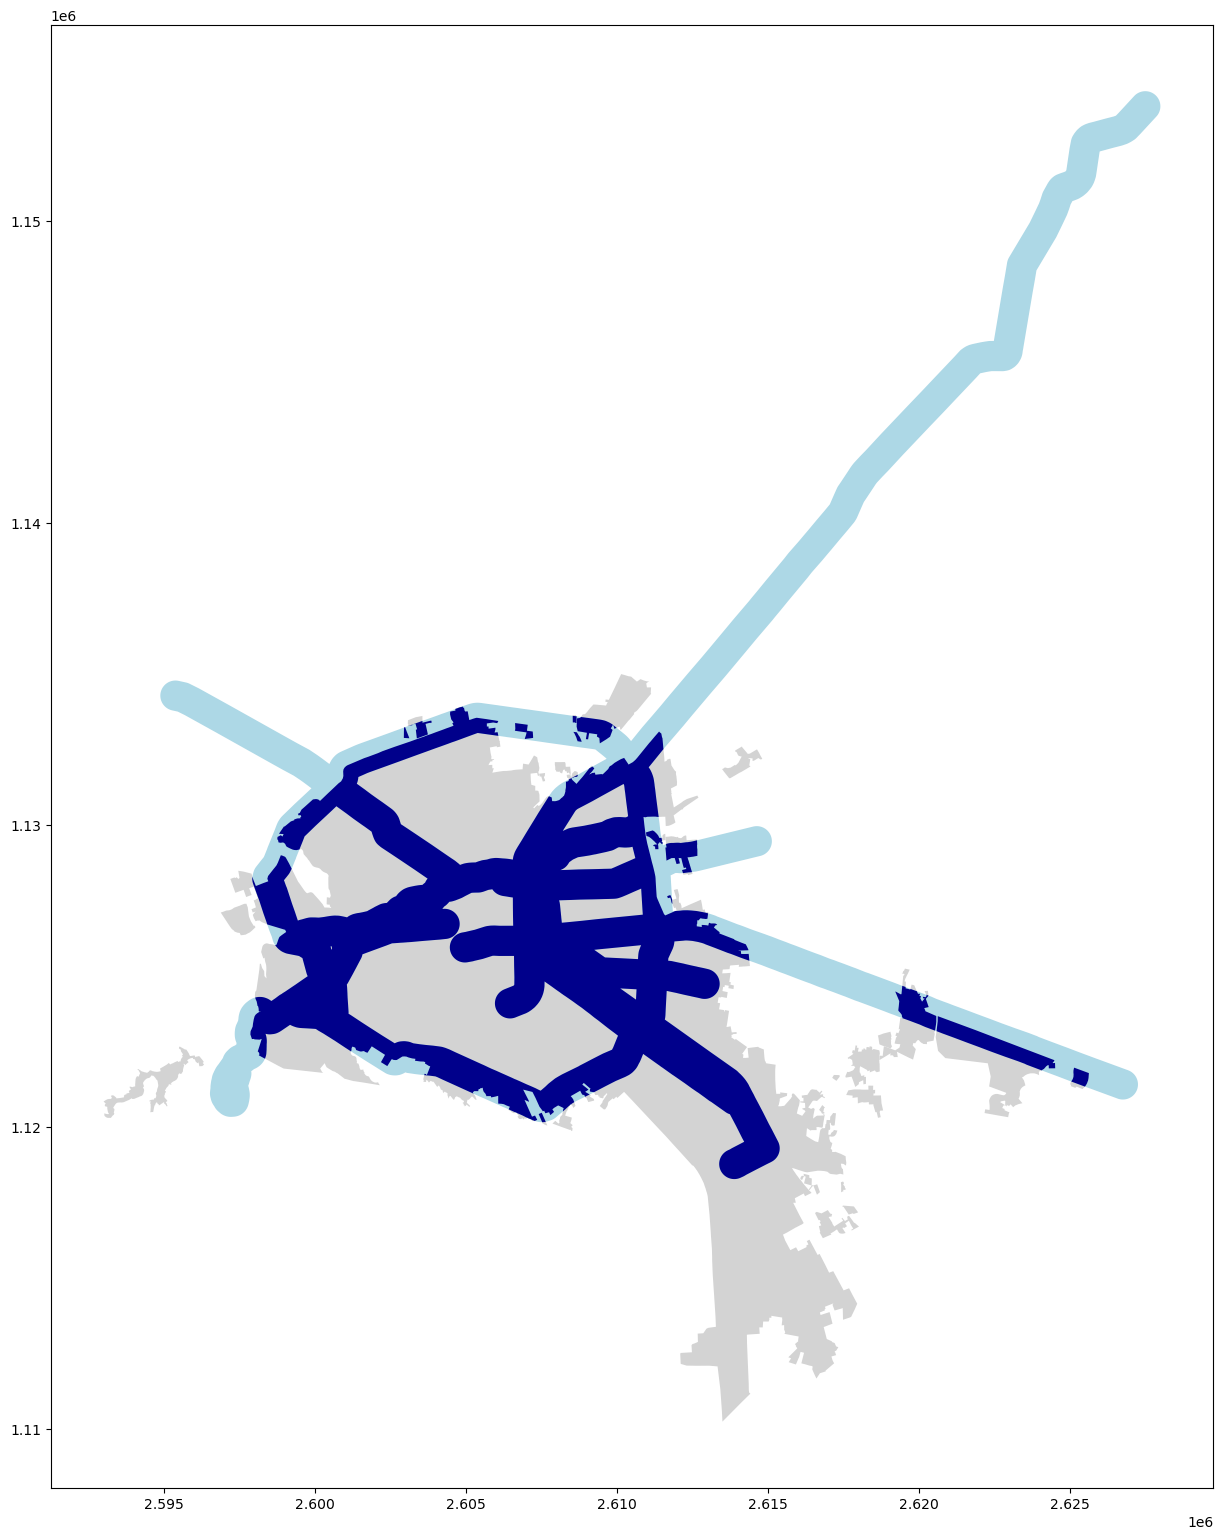

In [41]:
fig,ax = plt.subplots(figsize=(15,30))

city_buffer.plot(color='darkblue',ax=ax,zorder=2)
buffer_gdf.plot(color='lightblue',ax=ax,zorder=1)
city_aoi.plot(color='lightgrey',ax=ax,zorder=0)